# 1-GPU vs 4-GPU Scaling Analysis

## 1. Setup and Data Loading

This notebook analyzes the results from the scaling comparison test, aggregating data from folders marked with 'SCALE'. It now parses `batch_size` to correctly handle all experimental variations.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import pathlib
import json
import re

def parse_scaling_id(exp_name):
    # Updated regex to capture batch_size (B) as well
    m = re.search(r'SCALE_G(\d+).*RR(\d+).*B(\d+)', exp_name)
    if not m:
        # Fallback for old format without batch size
        m = re.search(r'SCALE_G(\d+).*RR(\d+)', exp_name)
        if not m:
            return None
        return {'gpu_count': int(m.group(1)), 'request_rate': int(m.group(2)), 'batch_size': 16} # Assume default batch size
    return {'gpu_count': int(m.group(1)), 'request_rate': int(m.group(2)), 'batch_size': int(m.group(3))}

root = pathlib.Path('../results/raw')
rows = []
if root.exists():
    for exp_dir in root.glob('*__SCALE_*'):
        if not exp_dir.is_dir(): continue
        meta = parse_scaling_id(exp_dir.name)
        if not meta: continue
        
        benchmark_dir = exp_dir / 'benchmark'
        try:
            result_file = next(benchmark_dir.glob('*.json'))
            with open(result_file, 'r') as f:
                data = json.load(f)
            meta.update({
                'request_throughput': data.get('request_throughput'),
                'total_token_throughput': data.get('total_token_throughput'),
                'mean_ttft_ms': data.get('mean_ttft_ms'),
                'mean_tpot_ms': data.get('mean_tpot_ms')
            })
            rows.append(meta)
        except (StopIteration, json.JSONDecodeError):
            print(f"Warning: Could not process result in {benchmark_dir}")

df_scale = pd.DataFrame(rows)
if 'request_rate' in df_scale.columns:
    # Sort by all key factors for consistent plotting
    df_scale = df_scale.sort_values(by=['gpu_count', 'batch_size', 'request_rate'])


## 2. Throughput Scaling Comparison (Factoring in Batch Size)

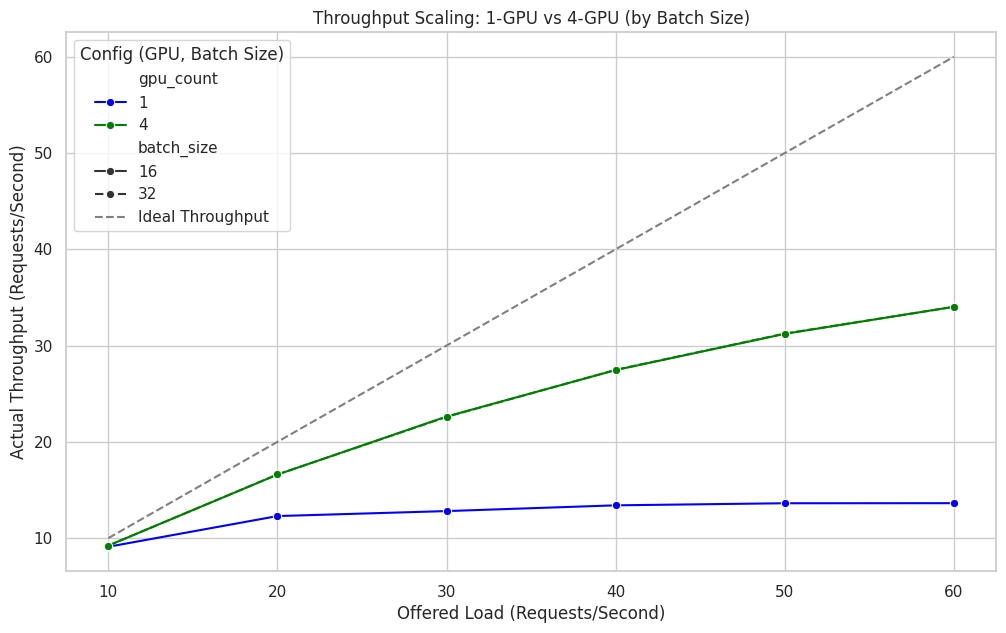

In [2]:
if not df_scale.empty:
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 7))
    
    sns.lineplot(data=df_scale, x='request_rate', y='request_throughput', hue='gpu_count', 
                 style='batch_size', marker='o', palette=['blue', 'green'])
    
    # Plot ideal throughput line for reference
    ideal_rates = sorted(df_scale['request_rate'].unique())
    plt.plot(ideal_rates, ideal_rates, 
             color='gray', linestyle='--', label='Ideal Throughput')
    
    plt.title('Throughput Scaling: 1-GPU vs 4-GPU (by Batch Size)')
    plt.xlabel('Offered Load (Requests/Second)')
    plt.ylabel('Actual Throughput (Requests/Second)')
    plt.legend(title='Config (GPU, Batch Size)')
    plt.grid(True)
    plt.savefig('../results/figs/scaling_throughput_comparison_by_batch_size.png')
    plt.show()

## 3. Latency Breakdown: TTFT vs. TPOT (Factoring in Batch Size)

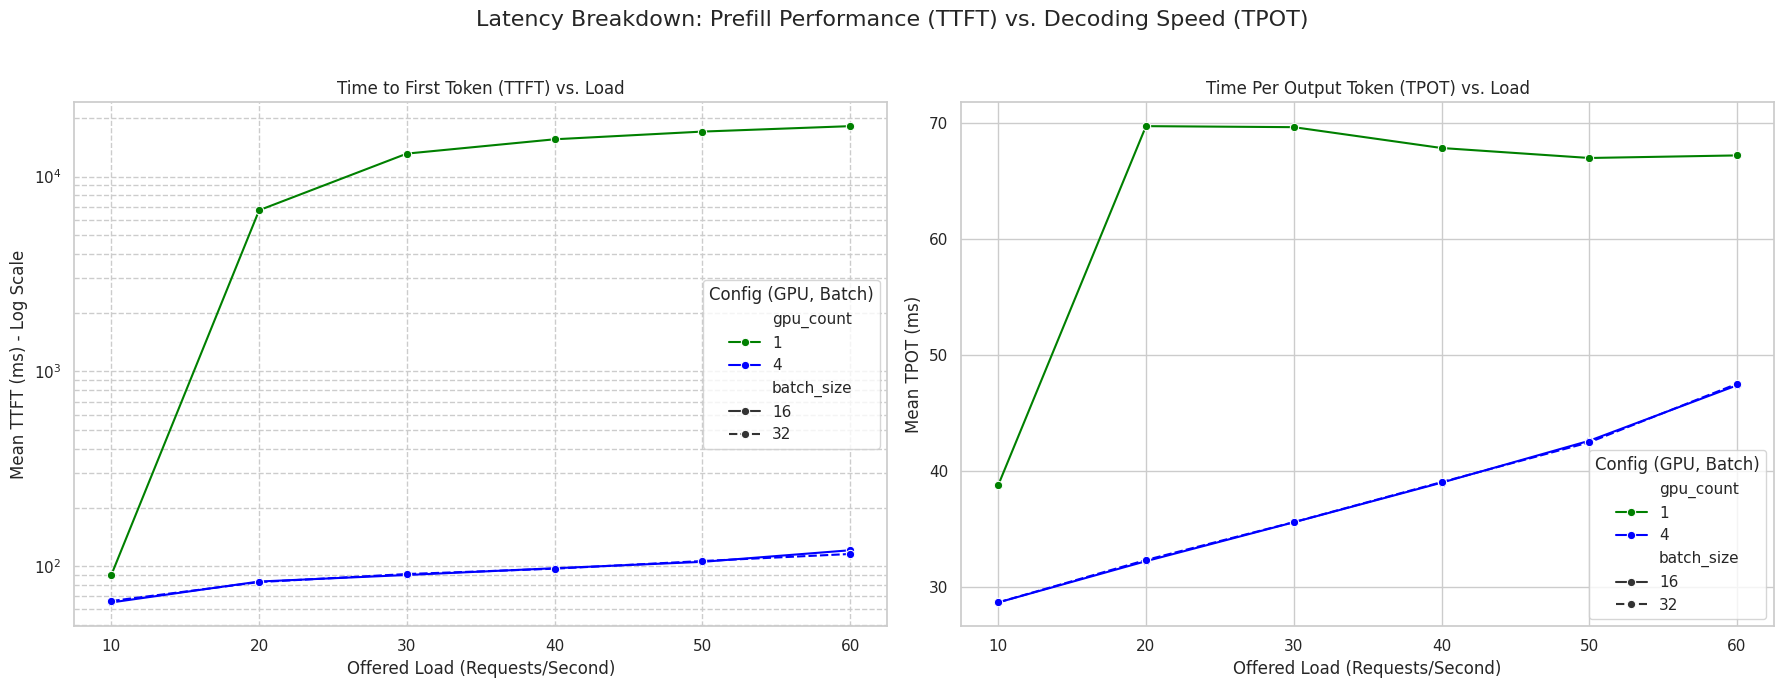

In [3]:
if 'df_scale' in locals() and not df_scale.empty:
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot 1: TTFT Comparison
    sns.lineplot(ax=axes[0], data=df_scale, x='request_rate', y='mean_ttft_ms', hue='gpu_count', 
                 style='batch_size', marker='o', palette=['green', 'blue'])
    axes[0].set_title('Time to First Token (TTFT) vs. Load')
    axes[0].set_xlabel('Offered Load (Requests/Second)')
    axes[0].set_ylabel('Mean TTFT (ms) - Log Scale')
    axes[0].set_yscale('log')
    axes[0].grid(True, which="both", ls="--")
    axes[0].legend(title='Config (GPU, Batch)')

    # Plot 2: TPOT Comparison
    sns.lineplot(ax=axes[1], data=df_scale, x='request_rate', y='mean_tpot_ms', hue='gpu_count', 
                 style='batch_size', marker='o', palette=['green', 'blue'])
    axes[1].set_title('Time Per Output Token (TPOT) vs. Load')
    axes[1].set_xlabel('Offered Load (Requests/Second)')
    axes[1].set_ylabel('Mean TPOT (ms)')
    axes[1].grid(True)
    axes[1].legend(title='Config (GPU, Batch)')
    
    fig.suptitle('Latency Breakdown: Prefill Performance (TTFT) vs. Decoding Speed (TPOT)', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('../results/figs/scaling_latency_breakdown_by_batch_size.png')
    plt.show()

## 4. Final Summary Table

In [4]:
if 'df_scale' in locals() and not df_scale.empty:
    # Create a summary table by averaging results for each configuration
    summary_table = df_scale.groupby(['gpu_count', 'batch_size', 'request_rate']).agg(
        avg_req_throughput=('request_throughput', 'mean'),
        avg_token_throughput=('total_token_throughput', 'mean'),
        avg_ttft_ms=('mean_ttft_ms', 'mean'),
        avg_tpot_ms=('mean_tpot_ms', 'mean')
    ).reset_index()
    
    print("Final Experiment Summary Table:")
    display(summary_table.round(2))

Final Experiment Summary Table:


,gpu_count,batch_size,request_rate,avg_req_throughput,avg_token_throughput,avg_ttft_ms,avg_tpot_ms
0,1,16,10,9.10,2723.33,90.22,38.80
1,1,16,20,12.29,3677.27,6714.42,69.76
2,1,16,30,12.80,3832.12,13112.12,69.67
3,1,16,40,13.40,4010.90,15530.45,67.87
4,1,16,50,13.62,4075.69,17009.42,67.01
5,1,16,60,13.63,4077.84,18138.17,67.24
6,4,16,10,9.23,2761.04,65.12,28.69
7,4,16,20,16.60,4967.70,83.38,32.24
8,4,16,30,22.63,6771.63,90.09,35.60
9,4,16,40,27.46,8216.61,97.59,39.01
